# DCO-OFDM with QAM 

To implement **DCO-OFDM with M-QAM** in **intensity-modulation/direct-detection (IM/DD)** based **indoor optical wireless communication (OWC)** systems, you must adapt conventional RF OFDM techniques to meet the constraints of optical systems — primarily **non-negativity** and **real-valued signals** for IM/DD.

### **Theory of M-QAM (Quadrature Amplitude Modulation)**

* **M-QAM** is a modulation scheme where information is encoded in both the **amplitude** and **phase** of a carrier wave.
* $M$ is the modulation order (e.g., 4-QAM, 16-QAM, 64-QAM, etc.), representing how many distinct symbols exist.
* Each symbol encodes $\log_2(M)$ bits.

* The QAM constellation is a grid of complex numbers in the I-Q plane.

  * For example, 16-QAM: 4x4 grid of points.
  * Each point is mapped from a binary sequence.

### Symbol Representation:

$$
s = I + jQ
$$

Where:

* $I$ (in-phase) and $Q$ (quadrature) are amplitude levels on the x and y axes.
* Typically drawn from a set like {±1, ±3} (normalized later to control power).

### **DCO-OFDM in IM/DD Optical Systems**

### Optical Constraints in IM/DD:

* **Intensity Modulation (IM)**: You modulate the **optical power** of the light source.
* **Direct Detection (DD)**: A photodetector (e.g., APD or PIN) detects **optical intensity** (non-coherent detection).
* Therefore:

  * \*\*Input signal to LED/VCSEL must be **real-valued and non-negative**.
  * Cannot directly transmit complex QAM symbols.

This is why **DCO-OFDM** (DC-biased Optical OFDM) is used.

### **Steps of DCO-OFDM with M-QAM**

### Step 1: QAM Symbol Mapping

* Bits → QAM symbols $s_k \in \mathbb{C}$
* For $M$-QAM, each symbol carries $\log_2 M$ bits.

### Step 2: Construct Hermitian Symmetric OFDM Symbol

* To ensure **real-valued time domain signal**:

  $$
  X = [0, X_1, X_2, ..., X_{N/2-1}, 0, X_{N/2-1}^*, ..., X_2^*, X_1^*]
  $$
* Only **half the subcarriers** are used for data → **spectral efficiency is halved**.
* The other half is filled to enforce Hermitian symmetry.

### Step 3: IFFT to Generate Time-Domain Signal

$$
x_n = \text{IFFT}(X_k)
$$

* $x_n \in \mathbb{R}$ due to Hermitian symmetry.
* But $x_n$ is bipolar (positive and negative values).

### Step 4: Add DC Bias

* To make the signal suitable for IM/DD, **add a DC bias**:

  $$
  x_n^{\text{IM}} = x_n + B
  $$

  Where $B$ is chosen such that $x_n^{\text{IM}} \geq 0$

### Step 5: Optical Transmission

* $x_n^{\text{IM}}$ modulates the optical intensity of the LED/VCSEL.
* The photodetector receives a signal proportional to intensity: $y(t) \propto x_n^{\text{IM}}$ + noise.

### **Receiver Processing**

1. **Remove DC bias** (if needed, or treat as noise)
2. **FFT** to convert back to frequency domain
3. **Extract active subcarriers**
4. **Equalize** (e.g., using channel estimates)
5. **QAM demodulation**
6. **Bit recovery**


### **Spectral Efficiency and Considerations**

* Only $N/2 - 1$ subcarriers carry complex data (excluding DC and Nyquist).
* DCO-OFDM spectral efficiency:

  $$
  R = \left(1 - \frac{1}{N/2}\right) \log_2(M) \text{ bits/subcarrier}
  $$
* DC bias introduces **power inefficiency**.
* Alternative: ACO-OFDM (only odd subcarriers, asymmetric clipping).


Let $s_k \in \mathbb{C}$ be the QAM symbols mapped to subcarriers.

1. Hermitian symmetry:

   $$
   X_k = \begin{cases}
   0, & k = 0 \\
   s_k, & 1 \leq k < N/2 \\
   0, & k = N/2 \\
   s_{N-k}^*, & N/2 < k < N
   \end{cases}
   $$

2. Time domain signal:

   $$
   x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k e^{j2\pi kn/N} \in \mathbb{R}
   $$

3. DC-biased signal:

   $$
   x_n^{\text{IM}} = x_n + B, \quad B \geq -\min(x_n)
   $$

4. Received signal:

   $$
   y_n = h * x_n^{\text{IM}} + n_n
   $$




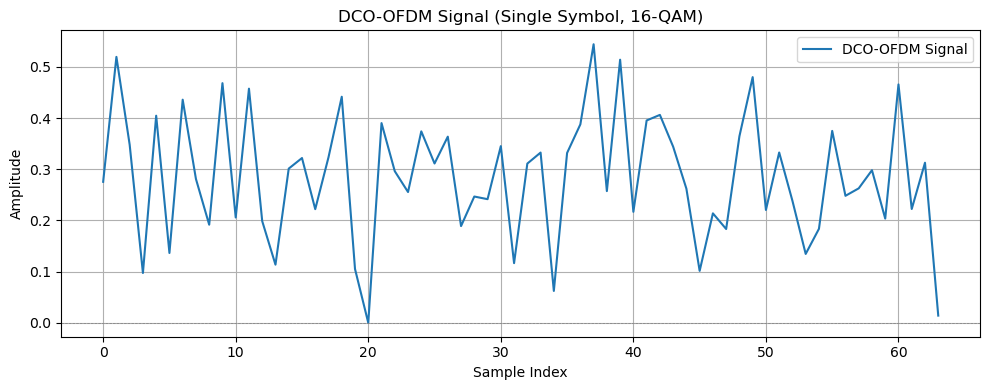

array([0.27542637, 0.51949765, 0.34791736, 0.09730115, 0.40457492,
       0.13637571, 0.43586482, 0.28095938, 0.1916188 , 0.46814331])

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

# Parameters
N = 64              # FFT size
M = 16              # 16-QAM
k = int(np.log2(M)) # Bits per QAM symbol
num_symbols = 1     # Just one OFDM symbol for signal inspection

# Gray-coded QAM mapping table
mapping_table = {
    (0,0,0,0): -3-3j, (0,0,0,1): -3-1j, (0,0,1,1): -3+1j, (0,0,1,0): -3+3j,
    (0,1,0,0): -1-3j, (0,1,0,1): -1-1j, (0,1,1,1): -1+1j, (0,1,1,0): -1+3j,
    (1,1,0,0):  1-3j, (1,1,0,1):  1-1j, (1,1,1,1):  1+1j, (1,1,1,0):  1+3j,
    (1,0,0,0):  3-3j, (1,0,0,1):  3-1j, (1,0,1,1):  3+1j, (1,0,1,0):  3+3j,
}
inv_mapping = {v: k for k, v in mapping_table.items()}

# QAM modulation function
def qam_mod(bits):
    symbols = []
    for i in range(0, len(bits), 4):
        b = tuple(bits[i:i+4])
        symbols.append(mapping_table[b])
    symbols = np.array(symbols)
    return symbols / np.sqrt(np.mean(np.abs(symbols)**2))  # Normalize

# Generate random bits and modulate
bits = np.random.randint(0, 2, k * (N//2 - 1))
qam_syms = qam_mod(bits)

# Create Hermitian symmetric vector
X = np.zeros(N, dtype=complex)
X[1:N//2] = qam_syms
X[N//2+1:] = np.conj(qam_syms[::-1])

# IFFT
x = np.real(ifft(X))

# Add DC bias for IM/DD
dc_bias = abs(np.min(x))
x_dc = x + dc_bias

# Plot signals
plt.figure(figsize=(10, 4))
plt.plot(x_dc, label='DCO-OFDM Signal')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title('DCO-OFDM Signal (Single Symbol, 16-QAM)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Output signal vector for inspection
x_dc[:10]  # first 10 samples


In [ ]:
import numpy as np
import scipy.io as sio

# Parameters
ifft_size = 720
cp_length = 80
num_symbols = 20
mod_order = 16  # QAM for optical (e.g., 16-QAM)
dc_index = ifft_size // 2

# Number of active subcarriers (excluding DC)
num_active = 109
half = num_active // 2
active_subcarriers = np.arange(dc_index - half, dc_index + half + 1)
active_subcarriers = active_subcarriers[active_subcarriers != dc_index]

bits_per_symbol = int(np.log2(mod_order))
total_bits = num_symbols * len(active_subcarriers) * bits_per_symbol
bits = np.random.randint(0, 2, total_bits)

# QAM Mapping
def qam_mod(bits, M):
    k = int(np.log2(M))
    symbols = []
    bit_groups = bits.reshape((-1, k))
    for b in bit_groups:
        val = int("".join(b.astype(str)), 2)
        sym = (2*(val % np.sqrt(M)) - np.sqrt(M) + 1) + 1j * (2*(val // np.sqrt(M)) - np.sqrt(M) + 1)
        symbols.append(sym)
    symbols = np.array(symbols)
    return symbols / np.sqrt((np.mean(np.abs(symbols)**2)))

qam_data = qam_mod(bits, mod_order)

# OFDM signal generation
ofdm_signal = []
symbol_matrix = np.zeros((num_symbols, ifft_size), dtype=complex)

for i in range(num_symbols):
    freq_data = np.zeros(ifft_size, dtype=complex)
    start = i * len(active_subcarriers)
    end = (i + 1) * len(active_subcarriers)
    this_symbol = qam_data[start:end]
    freq_data[active_subcarriers] = this_symbol
    freq_data[dc_index] = 0  # Explicit DC null
    symbol_matrix[i, :] = freq_data
    time_data = np.fft.ifft(np.fft.ifftshift(freq_data)) * np.sqrt(ifft_size)
    cp = time_data[-cp_length:]
    ofdm_symbol = np.concatenate([cp, time_data])
    ofdm_signal.extend(ofdm_symbol)

ofdm_signal = np.array(ofdm_signal)

# IM/DD constraints: signal must be real and non-negative
ofdm_signal = np.real(ofdm_signal)
dc_bias = abs(np.min(ofdm_signal)) + 0.1  # Add slight buffer
ofdm_signal_dc = ofdm_signal + dc_bias

# Normalize to unit power
ofdm_signal_dc /= np.sqrt(np.mean(ofdm_signal_dc**2))

# Add in-band noise
noise_snr_db = 30
signal_power = np.mean(ofdm_signal_dc**2)
noise_power = signal_power / (10**(noise_snr_db/10))
inband_noise = np.random.normal(0, np.sqrt(noise_power), ofdm_signal_dc.shape)
ofdm_signal_noisy = ofdm_signal_dc + inband_noise

# Add pre/post padding
left_pad = 600
right_pad = 1000
noise_std = np.sqrt(noise_power)
noise_before = np.random.normal(0, noise_std, left_pad)
noise_after = np.random.normal(0, noise_std, right_pad)
final_signal = np.concatenate([noise_before, ofdm_signal_noisy, noise_after])


